#Environment Setup

In [1]:

# Uninstall current TensorFlow, Keras, and other related packages
!pip uninstall -y tensorflow keras tensorflow-estimator tensorflow-text

# Install the specified TensorFlow version (2.17.0)
!pip install tensorflow==2.17.0 tensorflow-text==2.17.0

# Install other required dependencies
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install nltk
!pip install sacrebleu
!pip install ipython-autotime

# Load the autotime extension
%load_ext autotime

!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 21.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
time:

In [2]:
import logging
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text
import collections
import math
import string
import os
import json
import pickle
import sacrebleu
import zipfile
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import drive, files
import shutil
import datetime
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Mounted at /content/drive
time: 40.4 s (started: 2025-01-18 09:29:03 +00:00)


#Load Data and Data Splitting

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples = examples['train']
val_examples = examples['validation']

def filter_long_sentences(pt_sentence, en_sentence):
    pt_length = tf.shape(tf.strings.split(pt_sentence))[0]
    en_length = tf.shape(tf.strings.split(en_sentence))[0]
    return tf.logical_and(pt_length <= 35, en_length <= 35)


total_length = train_examples.reduce(0, lambda x, _: x + 1)

print(f"Total number of train examples: {total_length.numpy()}")

# Apply the filter to the datasets
train_examples = train_examples.filter(filter_long_sentences)
val_examples = val_examples.filter(filter_long_sentences)

total_length = train_examples.reduce(0, lambda x, _: x + 1)

print(f"Total number of train examples: {total_length.numpy()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.1PABXX_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.1PABXX_1.0.0/ted_hrlr_translate-val…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.1PABXX_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.
Total number of train examples: 51785
Total number of train examples: 46448
time: 32.1 s (started: 2025-01-18 09:29:55 +00:00)


# Subword Tokenizer

In [4]:
model_name = 'ted_hrlr_translate_pt_en_converter'
google_drive_path = '/content/drive/MyDrive/'
zip_file_path = f'{google_drive_path}{model_name}.zip'
extract_dir = "/content/"  # Define the directory to extract to


# Load the tokenizers
tokenizers = tf.saved_model.load('/content/drive/MyDrive/ted_hrlr_translate_pt_en_converter_extracted')

print("Model and tokenizers loaded successfully.")


Model and tokenizers loaded successfully.
time: 7.06 s (started: 2025-01-18 09:30:27 +00:00)


# Create Batches

In [5]:
MAX_TOKENS= 64
BUFFER_SIZE = 20000
BATCH_SIZE = 128
num_layers = 4
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1

time: 543 µs (started: 2025-01-18 09:31:25 +00:00)


In [6]:
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    pt = pt[:, :MAX_TOKENS]  # Trim to MAX_TOKENS
    pt = pt.to_tensor(shape=(None, MAX_TOKENS))  # Force padding to MAX_TOKENS

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS + 1)]  # Allow for START/END tokens
    en_inputs = en[:, :-1].to_tensor(shape=(None, MAX_TOKENS))  # Force padding to MAX_TOKENS
    en_labels = en[:, 1:].to_tensor(shape=(None, MAX_TOKENS))  # Force padding to MAX_TOKENS

    return (pt, en_inputs), en_labels


def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE, drop_remainder = True)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

time: 1.1 ms (started: 2025-01-18 09:31:28 +00:00)


In [7]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(128, 64)
(128, 64)
(128, 64)
time: 3.22 s (started: 2025-01-18 09:31:28 +00:00)


In [8]:
max_pt_length = tf.constant(0, dtype=tf.int32)
max_en_length = tf.constant(0, dtype=tf.int32)

# Iterate through the batches to find max lengths
for (pt, en), _ in train_batches:
    # Update max lengths for Portuguese and English
    max_pt_length = tf.maximum(max_pt_length, tf.reduce_max(tf.shape(pt)[1]))
    max_en_length = tf.maximum(max_en_length, tf.reduce_max(tf.shape(en)[1]))

print(f"Maximum Portuguese length: {max_pt_length.numpy()}")
print(f"Maximum English length: {max_en_length.numpy()}")

Maximum Portuguese length: 64
Maximum English length: 64
time: 6.86 s (started: 2025-01-18 09:31:31 +00:00)


# Positional Embedding

In [9]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

time: 1 ms (started: 2025-01-18 09:31:38 +00:00)


In [10]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)
print(pt_emb.shape)
print(en.shape)

(128, 64, 512)
(128, 64)
time: 2.15 s (started: 2025-01-18 09:31:38 +00:00)


# Multihead Attention (Transformer - Vanilla)

In [11]:
from keras.src import backend
from keras.src import constraints
from keras.src import initializers
from keras.src import ops
from keras.src import regularizers
from keras.src.api_export import keras_export
from keras.src.layers.activations.softmax import Softmax
from keras.src.layers.core.einsum_dense import EinsumDense
from keras.src.layers.layer import Layer
from keras.src.layers.regularization.dropout import Dropout


@keras_export("keras.layers.MultiHeadAttention")
class MultiHeadAttention(Layer):

    def __init__(
        self,
        num_heads,
        key_dim,
        value_dim=None,
        dropout=0.0,
        use_bias=True,
        output_shape=None,
        attention_axes=None,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.supports_masking = True
        self._num_heads = num_heads
        self._key_dim = key_dim
        # Cache 1.0 / math.sqrt(self._key_dim).
        self._inverse_sqrt_key_dim = None
        self._value_dim = value_dim if value_dim else key_dim
        self._dropout = dropout
        self._use_bias = use_bias
        self._output_shape = output_shape
        self._kernel_initializer = initializers.get(kernel_initializer)
        self._bias_initializer = initializers.get(bias_initializer)
        self._kernel_regularizer = regularizers.get(kernel_regularizer)
        self._bias_regularizer = regularizers.get(bias_regularizer)
        self._activity_regularizer = regularizers.get(activity_regularizer)
        self._kernel_constraint = constraints.get(kernel_constraint)
        self._bias_constraint = constraints.get(bias_constraint)
        if isinstance(attention_axes, int):
            attention_axes = (attention_axes,)
        elif attention_axes and not isinstance(attention_axes, (list, tuple)):
            raise ValueError(
                "`attention_axes` must be an int, list, or tuple."
                f"Received: attention_axes={attention_axes}"
            )
        self._attention_axes = attention_axes

    @property
    def num_heads(self):
        return self._num_heads

    @property
    def key_dim(self):
        return self._key_dim

    @property
    def value_dim(self):
        return self._value_dim

    @property
    def dropout(self):
        return self._dropout

    @property
    def use_bias(self):
        return self._use_bias

    @property
    def output_shape(self):
        return self._output_shape

    @property
    def attention_axes(self):
        return self._attention_axes

    def get_config(self):
        base_config = super().get_config()
        config = {
            "num_heads": self._num_heads,
            "key_dim": self._key_dim,
            "value_dim": self._value_dim,
            "dropout": self._dropout,
            "use_bias": self._use_bias,
            "output_shape": self._output_shape,
            "attention_axes": self._attention_axes,
            "kernel_initializer": initializers.serialize(
                self._kernel_initializer
            ),
            "bias_initializer": initializers.serialize(self._bias_initializer),
            "kernel_regularizer": regularizers.serialize(
                self._kernel_regularizer
            ),
            "bias_regularizer": regularizers.serialize(self._bias_regularizer),
            "activity_regularizer": regularizers.serialize(
                self._activity_regularizer
            ),
            "kernel_constraint": constraints.serialize(self._kernel_constraint),
            "bias_constraint": constraints.serialize(self._bias_constraint),
        }
        return {**base_config, **config}

    def build(
        self,
        query_shape,
        value_shape,
        key_shape=None,
    ):

        key_shape = value_shape if key_shape is None else key_shape
        query_rank = len(query_shape)
        value_rank = len(value_shape)
        key_rank = len(key_shape)
        einsum_equation, bias_axes, output_rank = _build_proj_equation(
            query_rank - 1, bound_dims=1, output_dims=2
        )
        self._query_dense = EinsumDense(
            einsum_equation,
            output_shape=_get_output_shape(
                output_rank - 1, [self._num_heads, self._key_dim]
            ),
            bias_axes=bias_axes if self._use_bias else None,
            name="query",
            **self._get_common_kwargs_for_sublayer(),
        )
        self._query_dense.build(query_shape)
        einsum_equation, bias_axes, output_rank = _build_proj_equation(
            key_rank - 1, bound_dims=1, output_dims=2
        )
        self._key_dense = EinsumDense(
            einsum_equation,
            output_shape=_get_output_shape(
                output_rank - 1, [self._num_heads, self._key_dim]
            ),
            bias_axes=bias_axes if self._use_bias else None,
            name="key",
            **self._get_common_kwargs_for_sublayer(),
        )
        self._key_dense.build(key_shape)
        einsum_equation, bias_axes, output_rank = _build_proj_equation(
            value_rank - 1, bound_dims=1, output_dims=2
        )
        self._value_dense = EinsumDense(
            einsum_equation,
            output_shape=_get_output_shape(
                output_rank - 1, [self._num_heads, self._value_dim]
            ),
            bias_axes=bias_axes if self._use_bias else None,
            name="value",
            **self._get_common_kwargs_for_sublayer(),
        )
        self._value_dense.build(value_shape)
        self._build_attention(output_rank)
        self._output_dense = self._make_output_dense(
            query_shape,
            self._get_common_kwargs_for_sublayer(),
            "attention_output",
        )
        output_dense_input_shape = list(
            self._query_dense.compute_output_shape(query_shape)
        )
        output_dense_input_shape[-1] = self._value_dim
        self._output_dense.build(tuple(output_dense_input_shape))
        self.built = True

    @property
    def query_dense(self):
        return self._query_dense

    @property
    def key_dense(self):
        return self._key_dense

    @property
    def value_dense(self):
        return self._value_dense

    @property
    def output_dense(self):
        return self._output_dense

    def _get_common_kwargs_for_sublayer(self):
        common_kwargs = dict(
            kernel_regularizer=self._kernel_regularizer,
            bias_regularizer=self._bias_regularizer,
            activity_regularizer=self._activity_regularizer,
            kernel_constraint=self._kernel_constraint,
            bias_constraint=self._bias_constraint,
            dtype=self.dtype_policy,
        )
        kernel_initializer = self._kernel_initializer.__class__.from_config(
            self._kernel_initializer.get_config()
        )
        bias_initializer = self._bias_initializer.__class__.from_config(
            self._bias_initializer.get_config()
        )
        common_kwargs["kernel_initializer"] = kernel_initializer
        common_kwargs["bias_initializer"] = bias_initializer
        return common_kwargs

    def _make_output_dense(self, query_shape, common_kwargs, name=None):

        query_rank = len(query_shape)
        if self._output_shape:
            if not isinstance(self._output_shape, collections.abc.Sized):
                output_shape = [self._output_shape]
            else:
                output_shape = self._output_shape
        else:
            output_shape = [query_shape[-1]]
        einsum_equation, bias_axes, output_rank = _build_proj_equation(
            query_rank - 1, bound_dims=2, output_dims=len(output_shape)
        )
        return EinsumDense(
            einsum_equation,
            output_shape=_get_output_shape(output_rank - 1, output_shape),
            bias_axes=bias_axes if self._use_bias else None,
            name=name,
            **common_kwargs,
        )

    def _build_attention(self, rank):
        if self._attention_axes is None:
            self._attention_axes = tuple(range(1, rank - 2))
        else:
            self._attention_axes = tuple(self._attention_axes)
        (
            self._dot_product_equation,
            self._combine_equation,
            attn_scores_rank,
        ) = _build_attention_equation(rank, attn_axes=self._attention_axes)
        norm_axes = tuple(
            range(
                attn_scores_rank - len(self._attention_axes), attn_scores_rank
            )
        )
        self._softmax = Softmax(axis=norm_axes, dtype=self.dtype_policy)
        self._dropout_layer = Dropout(
            rate=self._dropout, dtype=self.dtype_policy
        )
        self._inverse_sqrt_key_dim = 1.0 / math.sqrt(float(self._key_dim))

    def _masked_softmax(self, attention_scores, attention_mask=None):

        if attention_mask is not None:
            mask_expansion_axis = -len(self._attention_axes) * 2 - 1
            for _ in range(
                len(attention_scores.shape) - len(attention_mask.shape)
            ):
                attention_mask = ops.expand_dims(
                    attention_mask, axis=mask_expansion_axis
                )
        return self._softmax(attention_scores, mask=attention_mask)

    def _compute_attention(
        self, query, key, value, attention_mask=None, training=None
    ):

        query = ops.multiply(
            query, ops.cast(self._inverse_sqrt_key_dim, query.dtype)
        )

        # Take the dot product between "query" and "key" to get the raw
        # attention scores.
        attention_scores = ops.einsum(self._dot_product_equation, key, query)

        attention_scores = self._masked_softmax(
            attention_scores, attention_mask
        )

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        if self.dropout:
            final_attn_scores = self._dropout_layer(
                attention_scores, training=training
            )
        else:
            final_attn_scores = attention_scores

        # `context_layer` = [B, T, N, H]
        attention_output = ops.einsum(
            self._combine_equation, final_attn_scores, value
        )
        return attention_output, attention_scores

    def call(
        self,
        query,
        value,
        key=None,
        query_mask=None,
        value_mask=None,
        key_mask=None,
        attention_mask=None,
        return_attention_scores=False,
        training=None,
        use_causal_mask=False,
    ):
        if key is None:
            key = value

        attention_mask = self._compute_attention_mask(
            query,
            value,
            query_mask=query_mask,
            value_mask=value_mask,
            key_mask=key_mask,
            attention_mask=attention_mask,
            use_causal_mask=use_causal_mask,
        )

        #   N = `num_attention_heads`
        #   H = `size_per_head`
        # `query` = [B, T, N ,H]
        query = self._query_dense(query)

        # `key` = [B, S, N, H]
        key = self._key_dense(key)

        # `value` = [B, S, N, H]
        value = self._value_dense(value)

        attention_output, attention_scores = self._compute_attention(
            query, key, value, attention_mask, training
        )
        attention_output = self._output_dense(attention_output)

        if return_attention_scores:
            return attention_output, attention_scores
        return attention_output

    def _compute_attention_mask(
        self,
        query,
        value,
        query_mask=None,
        value_mask=None,
        key_mask=None,
        attention_mask=None,
        use_causal_mask=False,
    ):
        auto_mask = None
        if query_mask is not None:
            query_mask = ops.cast(query_mask, "bool")  # defensive casting
            # B = batch size, T = max query length
            auto_mask = ops.expand_dims(query_mask, -1)  # shape is [B, T, 1]
        if value_mask is not None:
            value_mask = ops.cast(value_mask, "bool")  # defensive casting
            # B = batch size, S == max value length
            mask = ops.expand_dims(value_mask, -2)  # shape is [B, 1, S]
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if key_mask is not None:
            key_mask = ops.cast(key_mask, "bool")  # defensive casting
            # B == batch size, S == max key length == max value length
            mask = ops.expand_dims(key_mask, -2)  # shape is [B, 1, S]
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if use_causal_mask:
            # the shape of the causal mask is [1, T, S]
            mask = self._compute_causal_mask(query, value)
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if auto_mask is not None:
            # merge attention_mask & automatic mask, to shape [B, T, S]
            attention_mask = (
                auto_mask
                if attention_mask is None
                else ops.cast(attention_mask, bool) & auto_mask
            )
        return attention_mask

    def _compute_causal_mask(self, query, value=None):

        q_seq_length = ops.shape(query)[1]
        v_seq_length = q_seq_length if value is None else ops.shape(value)[1]
        ones_mask = ops.ones((1, q_seq_length, v_seq_length), dtype="int32")
        row_index = ops.cumsum(ones_mask, axis=-2)
        col_index = ops.cumsum(ones_mask, axis=-1)
        return ops.greater_equal(row_index, col_index)

    def compute_output_shape(
        self,
        query_shape,
        value_shape,
        key_shape=None,
    ):
        if key_shape is None:
            key_shape = value_shape

        if query_shape[-1] != value_shape[-1]:
            raise ValueError(
                "The last dimension of `query_shape` and `value_shape` "
                f"must be equal, but are {query_shape[-1]}, {value_shape[-1]}. "
                "Received: query_shape={query_shape}, value_shape={value_shape}"
            )

        if value_shape[1:-1] != key_shape[1:-1]:
            raise ValueError(
                "All dimensions of `value` and `key`, except the last one, "
                f"must be equal. Received: value_shape={value_shape} and "
                f"key_shape={key_shape}"
            )

        if self._output_shape:
            return query_shape[:-1] + self._output_shape

        return query_shape

    def compute_output_spec(
        self,
        query,
        value,
        key=None,
        query_mask=None,
        value_mask=None,
        key_mask=None,
        attention_mask=None,
        return_attention_scores=False,
        training=None,
        use_causal_mask=False,
    ):
        if key is not None:
            key_shape = key.shape
        else:
            key_shape = None
        output_shape = self.compute_output_shape(
            query.shape, value.shape, key_shape
        )
        output_spec = backend.KerasTensor(
            output_shape, dtype=self.compute_dtype
        )
        if return_attention_scores:
            length = query.shape[1]
            attention_shape = (query.shape[0], self.num_heads, length, length)
            return output_spec, backend.KerasTensor(
                attention_shape, dtype=self.compute_dtype
            )
        return output_spec


def _index_to_einsum_variable(i):
    return string.ascii_lowercase[i]


def _build_attention_equation(rank, attn_axes):
    target_notation = ""
    for i in range(rank):
        target_notation += _index_to_einsum_variable(i)
    # `batch_dims` includes the head dim.
    batch_dims = tuple(np.delete(range(rank), attn_axes + (rank - 1,)))
    letter_offset = rank
    source_notation = ""
    for i in range(rank):
        if i in batch_dims or i == rank - 1:
            source_notation += target_notation[i]
        else:
            source_notation += _index_to_einsum_variable(letter_offset)
            letter_offset += 1

    product_notation = "".join(
        [target_notation[i] for i in batch_dims]
        + [target_notation[i] for i in attn_axes]
        + [source_notation[i] for i in attn_axes]
    )
    dot_product_equation = "%s,%s->%s" % (
        source_notation,
        target_notation,
        product_notation,
    )
    attn_scores_rank = len(product_notation)
    combine_equation = "%s,%s->%s" % (
        product_notation,
        source_notation,
        target_notation,
    )
    return dot_product_equation, combine_equation, attn_scores_rank


def _build_proj_equation(free_dims, bound_dims, output_dims):
    """Builds an einsum equation for projections inside multi-head attention."""
    input_str = ""
    kernel_str = ""
    output_str = ""
    bias_axes = ""
    letter_offset = 0
    for i in range(free_dims):
        char = _index_to_einsum_variable(i + letter_offset)
        input_str += char
        output_str += char

    letter_offset += free_dims
    for i in range(bound_dims):
        char = _index_to_einsum_variable(i + letter_offset)
        input_str += char
        kernel_str += char

    letter_offset += bound_dims
    for i in range(output_dims):
        char = _index_to_einsum_variable(i + letter_offset)
        kernel_str += char
        output_str += char
        bias_axes += char
    equation = f"{input_str},{kernel_str}->{output_str}"

    return equation, bias_axes, len(output_str)


def _get_output_shape(output_rank, known_last_dims):
    return [None] * (output_rank - len(known_last_dims)) + list(known_last_dims)

time: 6.76 ms (started: 2025-01-18 09:31:40 +00:00)


In [12]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

time: 442 µs (started: 2025-01-18 09:31:40 +00:00)


In [13]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

time: 463 µs (started: 2025-01-18 09:31:40 +00:00)


In [14]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(128, 64, 512)
(128, 64, 512)
(128, 64, 512)
time: 1.68 s (started: 2025-01-18 09:31:40 +00:00)


In [15]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

time: 488 µs (started: 2025-01-18 09:31:42 +00:00)


In [16]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(128, 64, 512)
(128, 64, 512)
time: 114 ms (started: 2025-01-18 09:31:42 +00:00)


In [17]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

time: 447 µs (started: 2025-01-18 09:31:42 +00:00)


In [18]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(128, 64, 512)
(128, 64, 512)
time: 118 ms (started: 2025-01-18 09:31:42 +00:00)


# Feed Forward Layer

In [19]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

time: 600 µs (started: 2025-01-18 09:31:42 +00:00)


In [20]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape) # `(batch_size, seq_len, d_model)`

(128, 64, 512)
(128, 64, 512)
time: 162 ms (started: 2025-01-18 09:31:42 +00:00)


# Encoder

## Encoder Layer

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

time: 566 µs (started: 2025-01-18 09:31:42 +00:00)


In [22]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(128, 64, 512)
(128, 64, 512)
time: 297 ms (started: 2025-01-18 09:31:42 +00:00)


## Encoder Block

In [23]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    x = self.pos_embedding(x)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

time: 737 µs (started: 2025-01-18 09:31:43 +00:00)


In [24]:

sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

print(pt.shape)
print(sample_encoder_output.shape)

(128, 64)
(128, 64, 512)
time: 1.53 s (started: 2025-01-18 09:31:43 +00:00)


# Decoder

## Decoder Layer

In [25]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)
    return x

time: 623 µs (started: 2025-01-18 09:31:44 +00:00)


In [26]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(128, 64, 512)
(128, 64, 512)
(128, 64, 512)
time: 442 ms (started: 2025-01-18 09:31:44 +00:00)


## Decoder Block

In [27]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    x = self.pos_embedding(x)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    return x

time: 747 µs (started: 2025-01-18 09:31:45 +00:00)


In [28]:
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)


print(en.shape)
print(pt_emb.shape)
print(output.shape)

(128, 64)
(128, 64, 512)
(128, 64, 512)
time: 2.62 s (started: 2025-01-18 09:31:45 +00:00)


# Transformer

## Model

In [29]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    context, x  = inputs

    context = self.encoder(context)

    x = self.decoder(x, context)


    logits = self.final_layer(x)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

time: 714 µs (started: 2025-01-18 09:31:47 +00:00)


## Hyperparameters

In [30]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(128, 64)
(128, 64)
(128, 64, 7010)
time: 6.28 s (started: 2025-01-18 09:31:47 +00:00)


## Optimizer

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

time: 626 µs (started: 2025-01-18 09:31:54 +00:00)


In [32]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

time: 4.16 ms (started: 2025-01-18 09:31:54 +00:00)


## Masked Loss and Masked Accuracy

In [33]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

time: 628 µs (started: 2025-01-18 09:31:54 +00:00)


# Train

## Compile

In [34]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

time: 5.24 ms (started: 2025-01-18 09:31:54 +00:00)


## Custom Callback

In [35]:
class SaveAndLoadCallback(tf.keras.callbacks.Callback):

    def __init__(self, save_dir='/content/drive/MyDrive/Transformer_enc4_head6_updated_t4/'):

        super().__init__()
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.history_path = os.path.join(save_dir, 'history.pkl')
        self.model_weights_path = os.path.join(save_dir, 'model_weights.weights.h5')
        self.optimizer_weights_path = os.path.join(save_dir, 'optimizer_weights.pkl')

    def on_epoch_end(self, epoch, logs=None):

        self.model.save_weights(self.model_weights_path)

        opt_weights = self.model.optimizer.variables
        with open(self.optimizer_weights_path, 'wb') as f:
            pickle.dump([w.numpy() for w in opt_weights], f)

        if os.path.exists(self.history_path):
            with open(self.history_path, 'rb') as f:
                history = pickle.load(f)
        else:
            history = {}

        history.setdefault('loss', []).append(logs.get('loss'))
        history.setdefault('val_loss', []).append(logs.get('val_loss'))
        history.setdefault('masked_accuracy', []).append(logs.get('masked_accuracy'))
        history.setdefault('val_masked_accuracy', []).append(logs.get('val_masked_accuracy'))

        with open(self.history_path, 'wb') as f:
            pickle.dump(history, f)

    def on_epoch_begin(self, epoch, logs=None):

        if os.path.exists(self.model_weights_path):
            self.model.load_weights(self.model_weights_path)

        if os.path.exists(self.optimizer_weights_path):
            with open(self.optimizer_weights_path, 'rb') as f:
                opt_weights = pickle.load(f)
            # Set the optimizer weights
            for var, weight in zip(self.model.optimizer.variables, opt_weights):
                var.assign(weight)

        if os.path.exists(self.history_path):
            with open(self.history_path, 'rb') as f:
                history = pickle.load(f)
            print("Epoch =",len(history['val_masked_accuracy']))

save_and_load_callback = SaveAndLoadCallback()

time: 2.18 ms (started: 2025-01-18 09:31:54 +00:00)


In [36]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

time: 248 µs (started: 2025-01-18 09:31:54 +00:00)


## Training

In [37]:
# history = transformer.fit(train_batches,
#                 epochs=16,
#                 callbacks=[early_stopping_callback],
#                 validation_data=val_batches)

time: 138 µs (started: 2025-01-18 09:31:54 +00:00)


In [38]:

zip_file_path = "/content/drive/MyDrive/T_E4_H8.zip"
model_weights_path = "model_weights.weights.h5"
optimizer_weights_path = "optimizer_weights.pkl"
history_path = "training_history.pkl"

# Unzip the files
with zipfile.ZipFile(zip_file_path, 'r') as zipf:
    zipf.extractall()  # Extracts all files to the current working directory
print("Files unzipped successfully.")

# Load model weights
transformer.load_weights(model_weights_path)
print("Model weights loaded successfully.")

# Load optimizer weights
with open(optimizer_weights_path, 'rb') as f:
    opt_weights = pickle.load(f)
for w, nw in zip(transformer.optimizer.variables, opt_weights):
    w.assign(nw)
print("Optimizer weights loaded successfully.")

# Load training history
with open(history_path, 'rb') as f:
    history = pickle.load(f)
print("Training history loaded successfully.")


Files unzipped successfully.
Model weights loaded successfully.
Optimizer weights loaded successfully.
Training history loaded successfully.
time: 29 s (started: 2025-01-18 09:31:54 +00:00)


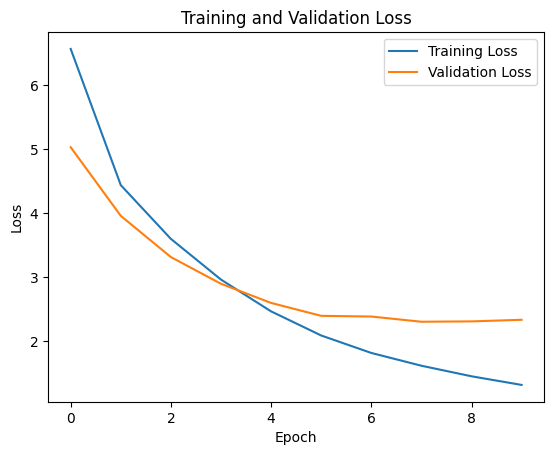

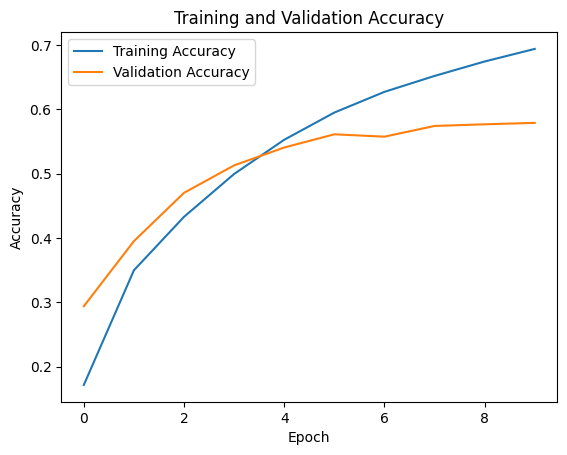

time: 310 ms (started: 2025-01-18 09:32:23 +00:00)


In [39]:
import matplotlib.pyplot as plt


plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(history['masked_accuracy'], label='Training Accuracy')
plt.plot(history['val_masked_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [40]:
def calculate_parameter_sparsity(model):
    total_elements = 0
    zero_elements = 0

    for variable in model.trainable_variables:
        total_elements += tf.size(variable).numpy()
        zero_elements += tf.reduce_sum(tf.cast(tf.abs(variable) <= 1e-3, tf.int32)).numpy()

    sparsity = zero_elements / total_elements
    print(total_elements)
    print(zero_elements)
    return sparsity

sparsity = calculate_parameter_sparsity(transformer)
print(f"Model parameter sparsity: {sparsity:.20%}")

128796002
7661965
Model parameter sparsity: 5.94891524660835369076%
time: 268 ms (started: 2025-01-18 09:32:23 +00:00)


In [41]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

time: 1.08 ms (started: 2025-01-18 09:32:23 +00:00)


In [42]:
translator = Translator(tokenizers, transformer)

time: 430 µs (started: 2025-01-18 09:32:23 +00:00)


In [43]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

time: 389 µs (started: 2025-01-18 09:32:23 +00:00)


Example 1:

In [44]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we need to solve .
Ground truth   : this is a problem we have to solve .
time: 4.37 s (started: 2025-01-18 09:32:23 +00:00)


Example 2:

In [45]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .
time: 2.03 s (started: 2025-01-18 09:32:28 +00:00)


Example 3:

In [46]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' ll share very quickly with some stories in some magic things that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.
time: 4.08 s (started: 2025-01-18 09:32:30 +00:00)


## Create attention plots

In [47]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.
time: 2.17 s (started: 2025-01-18 09:32:34 +00:00)


Create a function that plots the attention when a token is generated:

In [48]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

time: 600 µs (started: 2025-01-18 09:32:36 +00:00)


In [49]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

time: 5.18 ms (started: 2025-01-18 09:32:36 +00:00)


These are the input (Portuguese) tokens:

In [50]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

time: 18.9 ms (started: 2025-01-18 09:32:36 +00:00)


And these are the output (English translation) tokens:

In [51]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

time: 2.26 ms (started: 2025-01-18 09:32:36 +00:00)


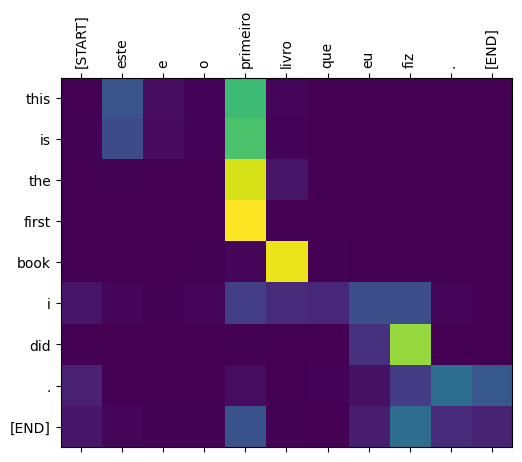

time: 144 ms (started: 2025-01-18 09:32:36 +00:00)


In [52]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [53]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

time: 570 µs (started: 2025-01-18 09:32:36 +00:00)


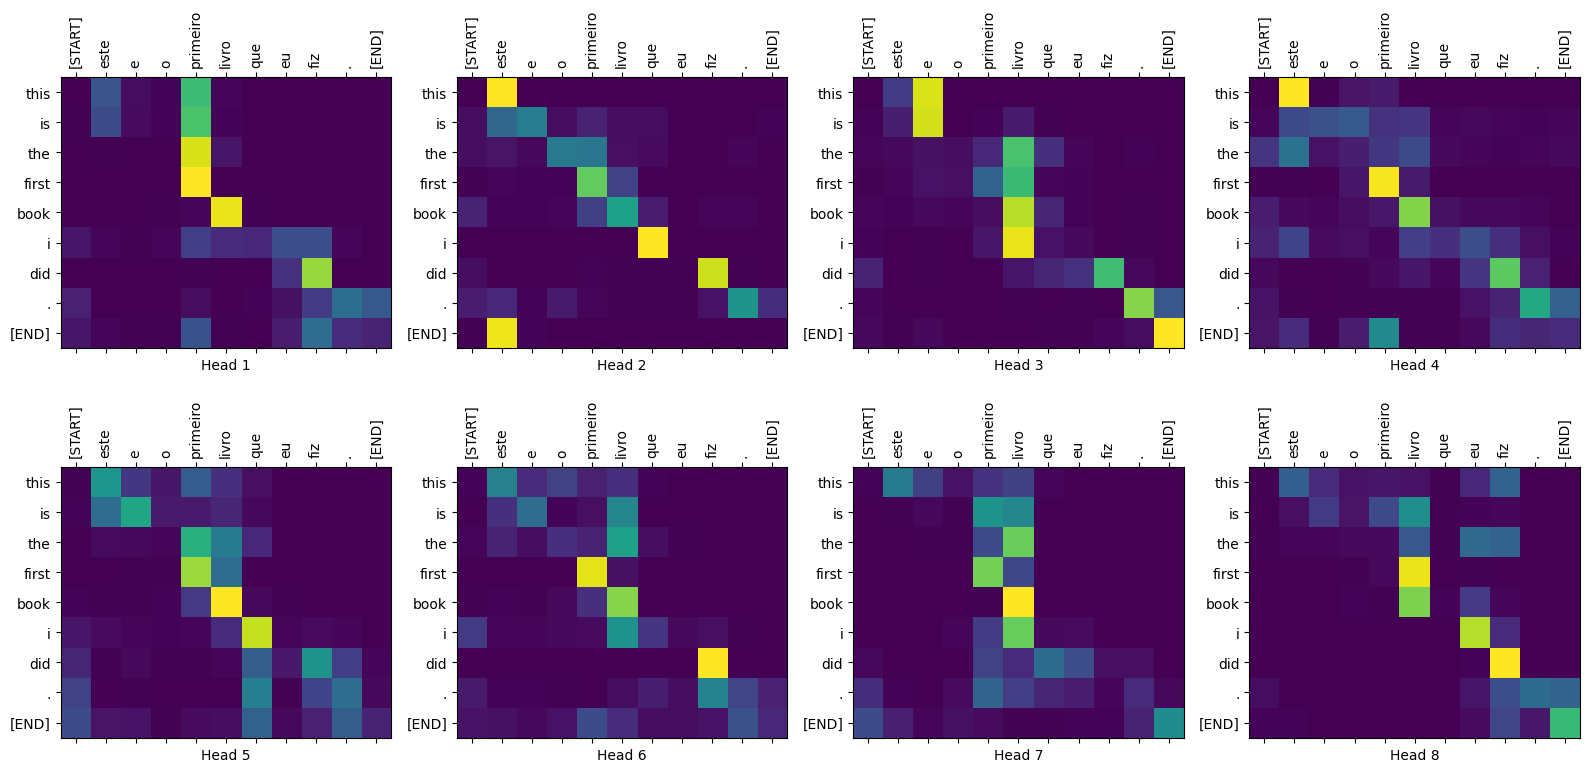

time: 831 ms (started: 2025-01-18 09:32:36 +00:00)


In [54]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about tribrosertic and cyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


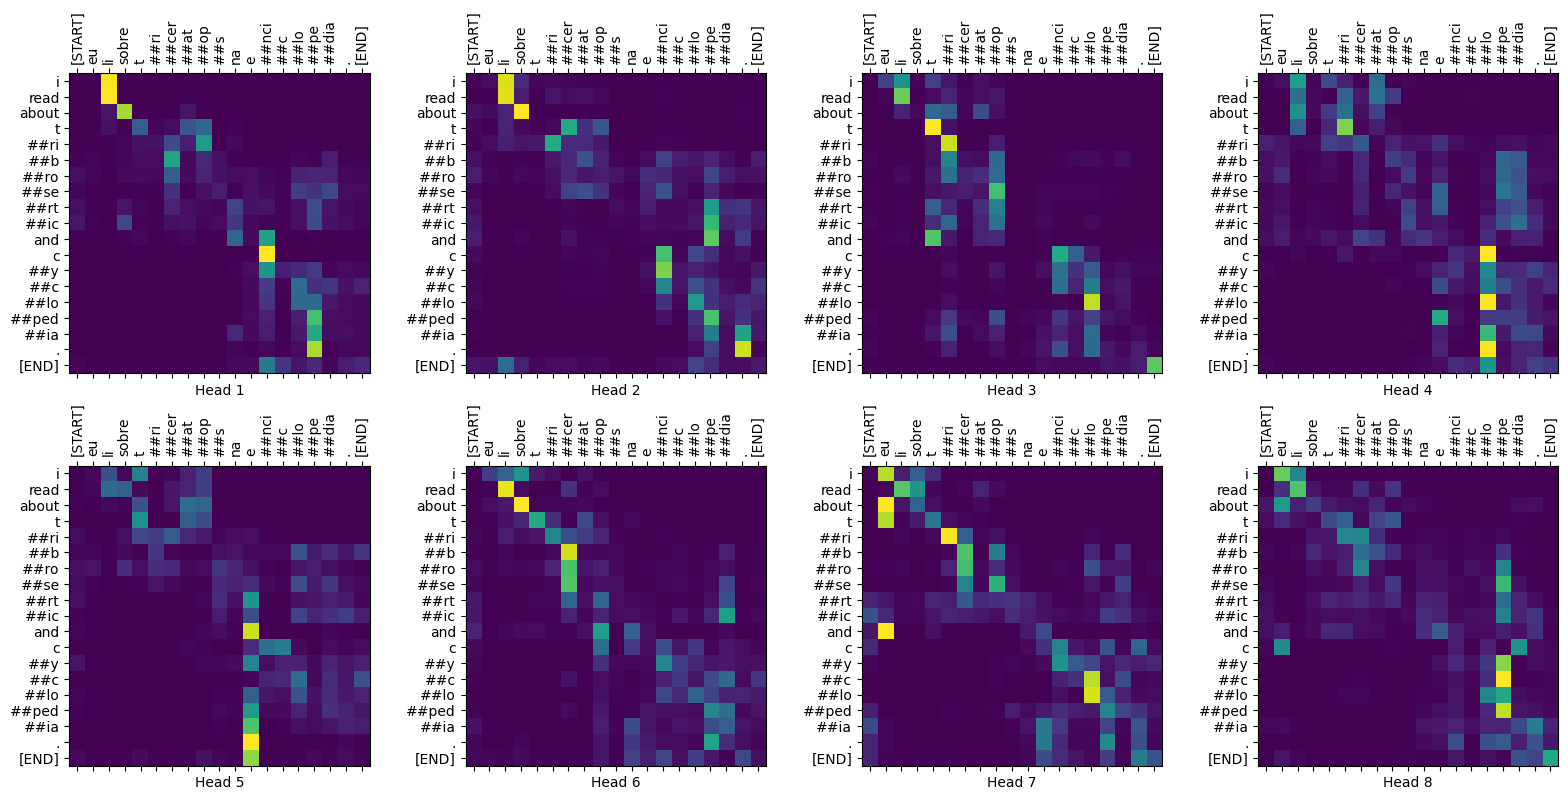

In [55]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

In [56]:
def generate_translations(translator, data):
    predicted = []
    references = []
    for pt, en in data:
        sentence = pt
        ground_truth = en

        translated_text, translated_tokens, attention_weights = translator(
            tf.constant(sentence))
        predicted.append(translated_text.numpy().decode('utf-8'))
        references.append([ground_truth.numpy().decode('utf-8')])
    return predicted, references

time: 5.56 s (started: 2025-01-18 09:32:37 +00:00)
time: 543 µs (started: 2025-01-18 09:32:42 +00:00)


In [57]:
def compute_bleu(translator, test_dataset):
    """Compute the BLEU score for the Translator model."""
    predictions, references = generate_translations(translator, test_dataset)
    # Calculate BLEU score using sacrebleu
    bleu = sacrebleu.corpus_bleu(predictions, references)
    print(f"BLEU score: {bleu.score:.8f}")
    return bleu.score

time: 384 µs (started: 2025-01-18 09:32:43 +00:00)


In [58]:
# Assuming you have a Translator instance and a test dataset
translator = Translator(tokenizers, transformer)

# Compute BLEU score on the test set
bleu_score = compute_bleu(translator, val_examples.take(500))

BLEU score: 17.28603923
time: 30min 2s (started: 2025-01-18 09:32:43 +00:00)
